# Cat/Dog Classifier

In [1]:
import numpy
numpy.random.seed(0)

import pandas
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load cat/dog image data, 
#  we resize the images for consistent model inputs.

transformation = transforms.Compose(
        [
            transforms.Resize((256,256)),
            transforms.ToTensor()
        ]
    )

train_dataset = datasets.ImageFolder("./data/training_set/", transform=transformation)
test_dataset = datasets.ImageFolder("./data/test_set", transform=transformation)

In [3]:
# data loader
batch_size = 40

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

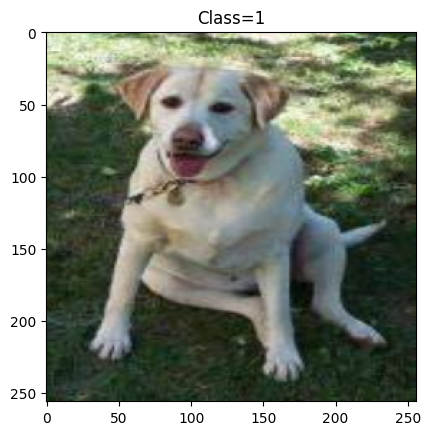

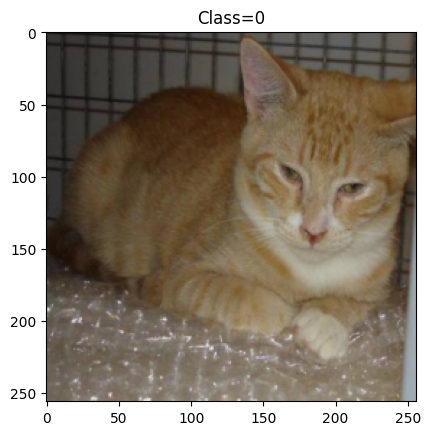

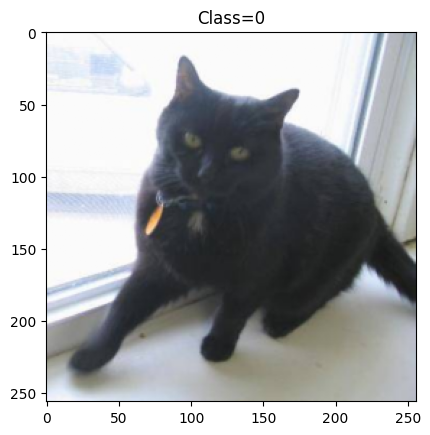

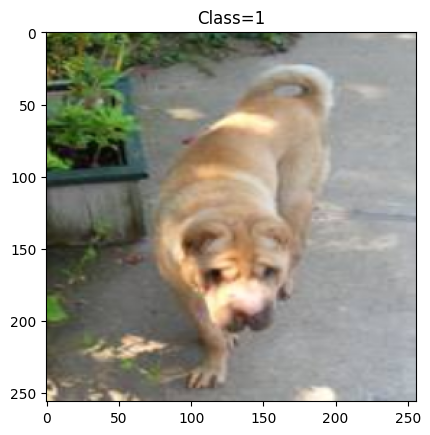

In [4]:
# quick check that the images are loaded, resized correctly and have the correct class labels.
imgs,labs = next(iter(train_loader))
for i,img in enumerate(imgs[0:4]):
    plt.figure()
    plt.title(f"Class={labs[i]}")
    plt.imshow(img.permute(1,2,0))

In [5]:
# CNN Architecture: 
#  5 convolutional layers, 
#  4 pooling layers,
#  6 fully connected layers.

class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=2),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=8, stride=2)
        )        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classification_layers = nn.Sequential(
            nn.Linear(256, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 256),
            nn.Tanh(),
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 2),
            nn.Tanh()
        )

    def forward(self,x):
        # convolutions
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.shape[0],1,-1)
        # classification 
        out = self.classification_layers(out)
        out = nn.Softmax(dim=2)(out)
        return out

model = ConvNet()

In [6]:
# Define Loss and Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.00001)

In [7]:
# Train the Model
num_epochs = 10

# record keeping for later plots and analytics
losses = list()
post_epoch_accuracy = list()

total_step = len(train_loader)
for epoch in range(num_epochs):

    # model training 
    for i, (images, labels) in enumerate(train_loader):

        # Forward Pass
        outputs = model(images).reshape(batch_size,-1)
        loss = criterion(outputs, labels)

        # Backwards and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # for plotting
        losses.append((epoch, loss.item()))

        if (i+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step[{i+1}/{total_step}]: Loss = {loss.item():.4f}")


    # model evaluation after each epoch
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images).reshape(batch_size,2)
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct/total
        print(f"Test Accuracy: {(100*accuracy):.4f}%.")
        post_epoch_accuracy.append(accuracy)

losses = pandas.DataFrame(losses, columns=["Epoch","Loss"])

Epoch 1/10, Step[10/200]: Loss = 0.6952
Epoch 1/10, Step[20/200]: Loss = 0.6884
Epoch 1/10, Step[30/200]: Loss = 0.6914
Epoch 1/10, Step[40/200]: Loss = 0.6965
Epoch 1/10, Step[50/200]: Loss = 0.6672
Epoch 1/10, Step[60/200]: Loss = 0.6751
Epoch 1/10, Step[70/200]: Loss = 0.6832
Epoch 1/10, Step[80/200]: Loss = 0.6798
Epoch 1/10, Step[90/200]: Loss = 0.7015
Epoch 1/10, Step[100/200]: Loss = 0.6578
Epoch 1/10, Step[110/200]: Loss = 0.6490
Epoch 1/10, Step[120/200]: Loss = 0.6879
Epoch 1/10, Step[130/200]: Loss = 0.6790
Epoch 1/10, Step[140/200]: Loss = 0.6743
Epoch 1/10, Step[150/200]: Loss = 0.6729
Epoch 1/10, Step[160/200]: Loss = 0.6447
Epoch 1/10, Step[170/200]: Loss = 0.6709
Epoch 1/10, Step[180/200]: Loss = 0.5996
Epoch 1/10, Step[190/200]: Loss = 0.6864
Epoch 1/10, Step[200/200]: Loss = 0.6511
Test Accuracy: 66.1000%.
Epoch 2/10, Step[10/200]: Loss = 0.5983
Epoch 2/10, Step[20/200]: Loss = 0.6007
Epoch 2/10, Step[30/200]: Loss = 0.6296
Epoch 2/10, Step[40/200]: Loss = 0.6493
Epoc

In [8]:
# Evaluate the final model on test set
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images).reshape(batch_size,2)
        _,predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = correct/total
    print(f"Test Accuracy: {(100*accuracy):.4f}%.")

Test Accuracy: 77.0500%.


# Visualisations

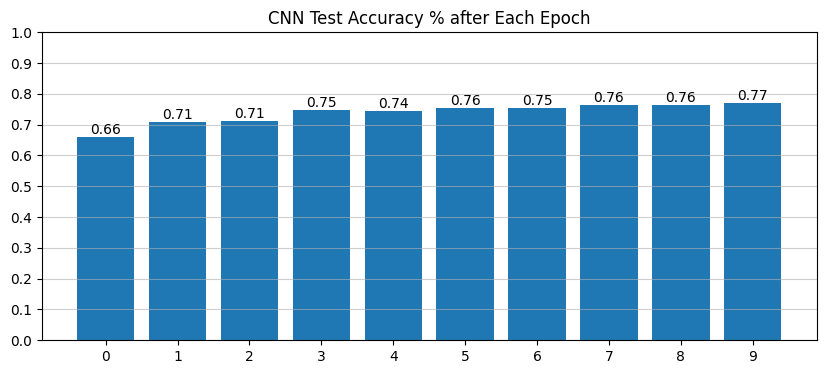

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
bars = ax.bar(list(range(num_epochs)), post_epoch_accuracy)
ax.bar_label(bars, fmt='%.2f')
plt.title("CNN Test Accuracy % after Each Epoch")
plt.xticks(list(range(num_epochs)))
plt.yticks(numpy.linspace(0,1,11))
plt.grid(axis='y', alpha=0.6)


plt.show()

Text(0.5, 1.0, 'Loss per Batch with Trend in Black')

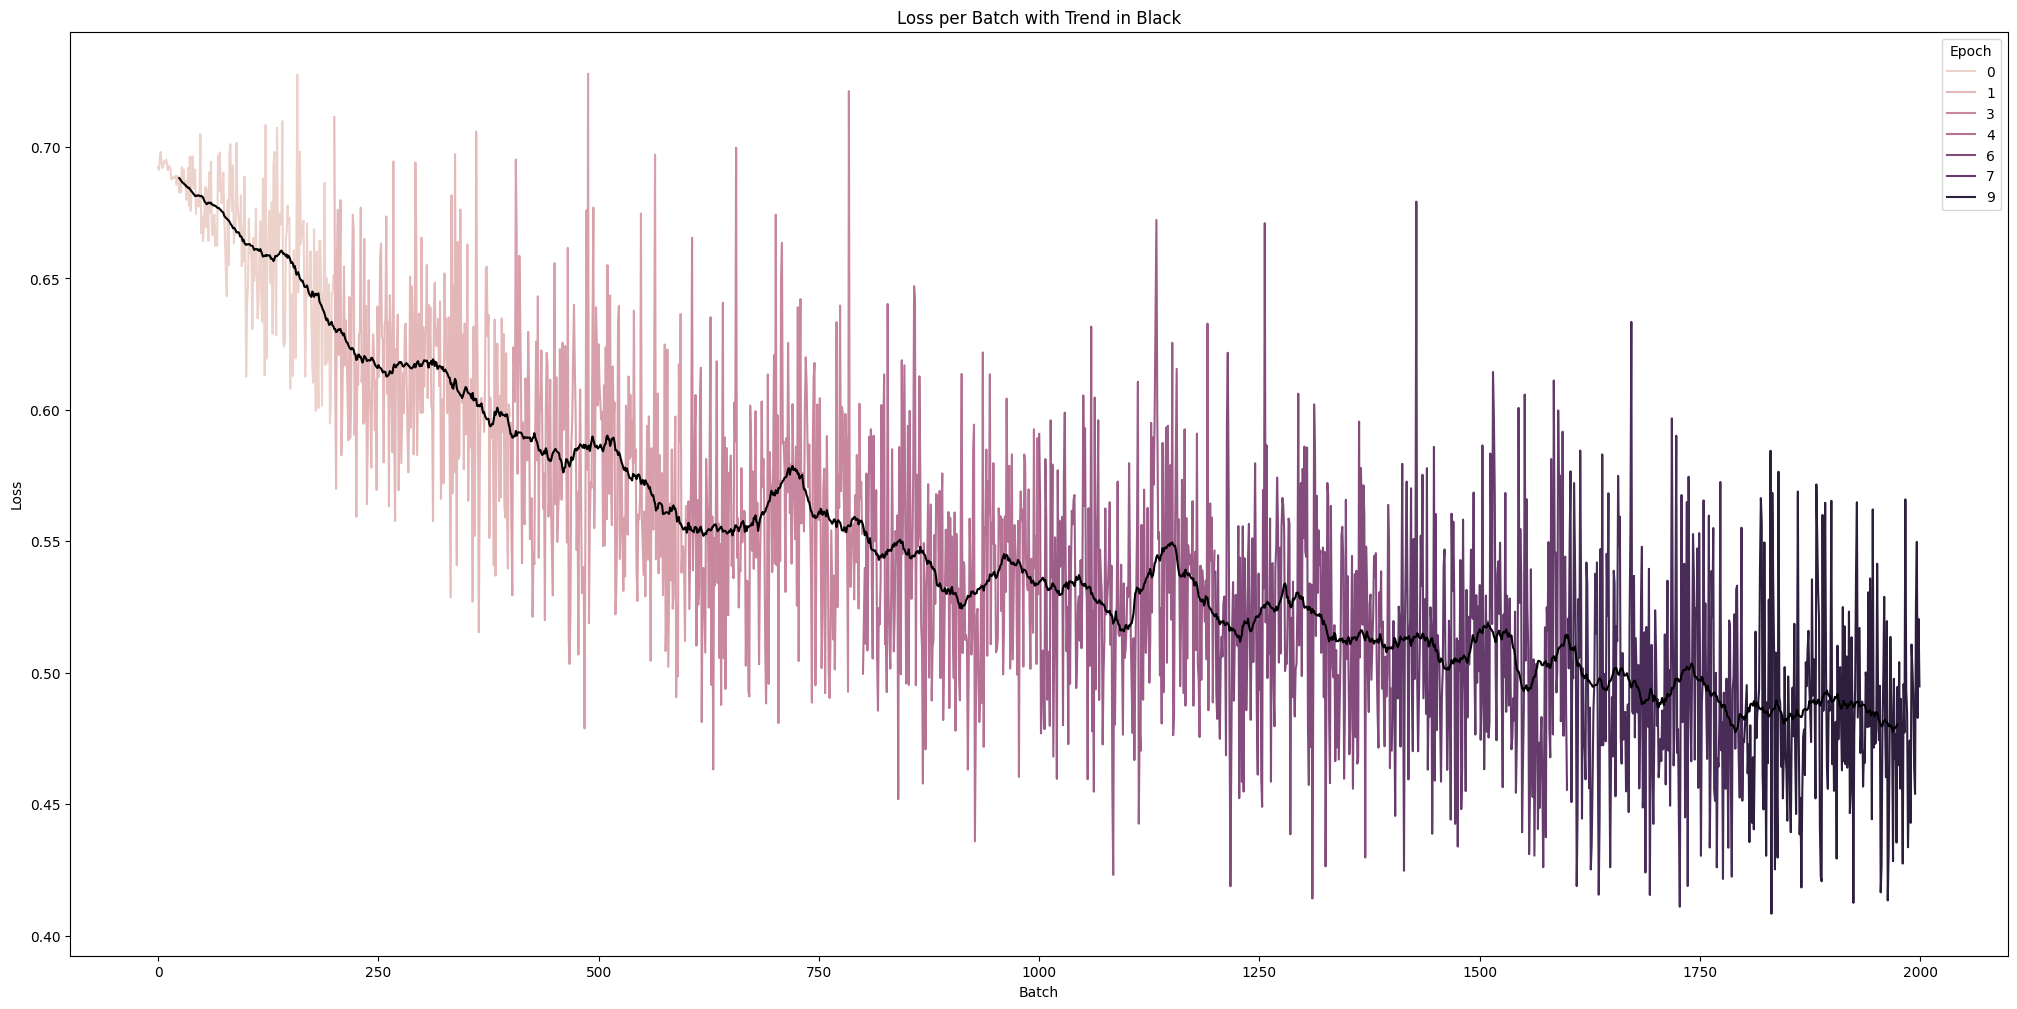

In [10]:
plt.figure(figsize=(25,12))
plt.style.use('default')
sns.lineplot(data=losses, y='Loss', x=losses.index, hue='Epoch')
plt.plot(losses.Loss.rolling(window=50).mean()[25:].reset_index().Loss, color="black")
plt.xlabel("Batch")
plt.title("Loss per Batch with Trend in Black")